In [54]:
import numpy as np
import time
import math
import modules as md
#import nbodysolver as nbs
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge
import matplotlib.patches as mpatches

#------------------------------------------------------------------------------------------
#Units and conversions:
#------------------------------------------------------------------------------------------
#code units: Rsun, Msun, G=1, ...
c_SI       = 299792458.0        #m/s
M_sun_SI   = 1.989*(10.**30.)   #kg
R_sun_SI   = 695800000.         #m
R_bull_SI = 1000 #m 
AU_SI      = 149597871000.      #m 
G_new_SI   = 6.67*(10.**(-11.)) #m**3 kg**(-1) s**(-2)
AU_U       = AU_SI/R_sun_SI                             #from dist AU to code units (U)
kmsec_U    = 1000./np.sqrt(G_new_SI*M_sun_SI/R_bull_SI)  #from vel km/sec to code units (U)
time_U     = 1/np.sqrt(G_new_SI*M_sun_SI/R_bull_SI**3) #from CU to second np.sqrt((R_bull_SI)/(G_new_SI*M_sun_SI)) #from code units(U) to time sec
#Rsch_1Msun_unitRsun = ((2.*G_new_SI*(1.*M_sun_SI))/(c_SI**2.))/R_sun_SI
c_CU = c_SI/1000*kmsec_U

# Newtonian 

In [55]:
#Acceleration

def acc(r,m): #r position, m mass
    a = np.zeros((len(r),3)) #Create acceleration vector
    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle
            if (i != j):
                rrel = r[i]-r[j]
                rn = (rrel**2).sum()**(1./2) 
                a[i] += -(rrel)*m[j]/(rn**3.0) #Acceleration at each time step 
    return a # return acceleration


def Jerk(r,v,m): #position, velocity, mass
    Je = np.zeros((len(r),3)) #Define the Jerk
    for i in range(len(r)):
        for j in range(len(r)):
            if (i != j):
                rrel = r[i]-r[j]
                vrel = v[i]-v[j]
                rn = (rrel**2).sum()**(1./2) # dot product
                vn = (vrel**2).sum()**(1./2)
                rvd = ((rrel)*(vrel)).sum()
                Je[i] += - m[j]*((vrel)/rn**3.0 - 3.*(rvd*rrel/(rn**5.0))) 
    return Je;

# Spin-Orbit

In [56]:
def accspinorb(r,v,m,ns,S,I):#r,m,S,ns #r position, m mass, s spin, m mass of the star and the value of ne
    a = np.zeros((len(r),3))#Create acceleration vector
    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle
            if (i != j):
                rrel = r[i]-r[j]
                vrel = v[i]-v[j]
                rn = ((rrel**2).sum())**(1./2) #dot product
                runi = rrel/rn
                Sn = ((S[i]*S[i]).sum())**(1./2)
                rucv = np.cross(runi,vrel) 
                rucS = np.cross(runi,S[i])
                vcS = np.cross(vrel,S[i])
                rudv = (runi*vrel).sum()
                a1 = 3*runi*((rucv*S[i]).sum())
                a2 = 2*vcS
                a3 = 3*(rudv)*(rucS)
                a[i] += (1./(c_CU**2))*(2+(3.*m[j]/(2.*m[i])))*(I[i]/rn**3)*(a1 + a2 + a3)
                #a[i] += -(3./2)*ns[i]*(m[j]*Sn**2/m[i])*(runi)/(rn**4.0) #Acceleration at each time step
    return a # return acceleration

def Jerkspinorb(r,v,m, ns,S):#r,v,m,S,ns #r position, v velocity, m mass, m mass of the star, ne
    Je = np.zeros((len(r),3)) #Define the Jerk
    Je1 = np.zeros((len(r),3))
    Je2 = np.zeros((len(r),3))
    for i in range(len(r)):
        for j in range(len(r)):
            if (i != j):
                rrel = (r[i]-r[j])
                vrel = (v[i]-v[j])
                rn = ((rrel**2).sum())**(1./2) # dot product
                Sn = ((S[i]*S[i]).sum())**(1./2)
                #Je1[i] += - (3./2)*ns[i]*((m[j])/m[i])*(2*((S*b).sum())*rrel/r**5 ) #Still need to define b 
                Je2[i] += 0 #- (3./2)*ns[i]*((m[j])/m[i])*(Sn**2)*(vrel/rn**5.0 - 5.*((vrel*rrel).sum())*(rrel)/(rn**7.0))               
                Je[i] += Je2[i] #Je1[i] + Je2[i] 
    return Je;

def bccspinorb(r,v,m,ns,S,I): #r position, m mass, s spin, m mass of the star
    b = np.zeros((len(r),3)) #Create acceleration vector
    b1 = np.zeros((len(r),3))
    b2 = np.zeros((len(r),3))
    #bden = np.zeros((len(r),3))
    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle
            if (i != j):
                if(ns[i] == 0.0):
                    b[i] = np.array([0,0,0])
                elif (ns[i] != 0):
                    rrel = r[i]-r[j]
                    rn = ((rrel**2).sum())*(1./2)
                    vrel = v[i] - v[j]
                    mu = m[i]*m[j]/(m[i] + m[j])
                    L = mu*( np.cross(rrel, vrel) )
                    b1[i] += np.cross(L, S[i])#(2 + (3*m[j]/(2*m[i])))*( np.cross(L, S[i]) )*(1/(rn**3.0))
                    #b2[i] += 
                    b[i] = b1[i] #b1[i] #+ b2[i]
    return b # return acceleration

# Tidal Spin

In [57]:
def accspin(r,m,ns,S):#r,m,S,ns #r position, m mass, s spin, m mass of the star and the value of ne
    a = np.zeros((len(r),3)) #Create acceleration vector
    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle
            if (i != j):
                rrel = r[i]-r[j]
                rn = ((rrel**2).sum())**(1./2) #dot product
                runi = rrel/rn
                Sn = ((S[i]*S[i]).sum())**(1./2)
                a[i] += -(3./2)*ns[i]*(m[j]*Sn**2/m[i])*(runi)/(rn**4.0) #Acceleration at each time step
                
    return a # return acceleration

def Jerkspin(r,v,m, ns,S):#r,v,m,S,ns #r position, v velocity, m mass, m mass of the star, ne
    Je = np.zeros((len(r),3)) #Define the Jerk
    Je1 = np.zeros((len(r),3))
    Je2 = np.zeros((len(r),3))
    for i in range(len(r)):
        for j in range(len(r)):
            if (i != j):
                rrel = (r[i]-r[j])
                vrel = (v[i]-v[j])
                rn = ((rrel**2).sum())**(1./2) # dot product
                Sn = ((S[i]*S[i]).sum())**(1./2)
                #Je1[i] += - (3./2)*ns[i]*((m[j])/m[i])*(2*((S*b).sum())*rrel/r**5 ) #Still need to define b 
                Je2[i] += - (3./2)*ns[i]*((m[j])/m[i])*(Sn**2)*(vrel/rn**5.0 - 5.*((vrel*rrel).sum())*(rrel)/(rn**7.0))               
                Je[i] += Je2[i] #Je1[i] + Je2[i] 
    return Je;

#Spin evolution
def bccspin(r,v,m,ns,S,I): #r position, m mass, s spin, m mass of the star
    b = np.zeros((len(r),3)) #Create acceleration vector
    b1 = np.zeros((len(r),3))
    b2 = np.zeros((len(r),3))
    #bden = np.zeros((len(r),3))
    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle
            if (i != j):
                if(ns[i] == 0.0):
                    b[i] = np.array([0,0,0])
                elif (ns[i] != 0):
                    rrel = r[i]-r[j]
                    rn = ((rrel**2).sum())*(1./2)
                    runi = 1.*rrel/rn
                    vrel = v[i] - v[j]
                    rdv = (rrel*vrel).sum()
                    Sn = ((S[i]*S[i]).sum())**(1./2)
                    acccor = (m[j]*ns[i]/rn**3)
                    #bden[i] = I[i] #(I[i] + m[j]*ns[i]/rn**3)
                    b1[i] += (1/(I[i] + acccor))*(3*ns[i]*m[j]*rdv*S[i])*(1/(rn**5.0))
                    #b2[i] += 
                    b[i] = b1[i] #b1[i] #+ b2[i]
    return b # return acceleration

# Post-Newtonian 

In [58]:
#PN Acceleration
def accPN(r,v,m): #r position, m mass, s spin, m mass of secondary
    a = np.zeros((len(r),3)) #Create acceleration vector
    a1 = np.zeros((len(r),3)) #Create acceleration vector
    a2 = np.zeros((len(r),3)) #Create acceleration vector

    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle           
            if (i != j):
                rrel = r[i]-r[j] 
                vrel = v[i]-v[j]
                rn = ((rrel**2).sum())**(1./2) #dot product
                runi = 1.*rrel/rn
                #rvd = ((rrel)*(vrel)).sum()
                ruvd = ((runi)*(vrel)).sum()
                v2d = (vrel**2).sum()
                a1[i] += +(4./5)*(1./c_CU**5)*(m[i]*m[j]/(rn**3))*((2*m[i]/rn - 8*m[j]/rn - v2d)*vrel)
                a2[i] += +(4./5)*(1./c_CU**5)*(m[i]*m[j]/(rn**3))*(runi*(ruvd)*(52.0*m[j]/(3*rn) - 6*m[i]/rn + 3.0*v2d))
                a[i] += a1[i] + a2[i] #a1[i] +  
    return a#, a1, a2 # return acceleration


#PN Jerk v2

def JerkPN(r,v,a,m): #position, velocity, mass
    JePNLO3 = np.zeros((len(r),3))
    JePNLO3v2 = np.zeros((len(r),3))
    JePNLO4 = np.zeros((len(r),3))
    JePNLO5 = np.zeros((len(r),3))#Define the Jerk
    for i in range(len(r)):
        for j in range(len(r)):
            if (i != j):
                rrel = r[i]-r[j] 
                vrel = v[i]-v[j]
                arel = a[i]-a[j]
                rn = ((rrel**2).sum())**(1./2) #norm                                                    
                vn = ((vrel**2).sum())**(1./2) 
                runi = 1.*rrel/rn
                ruvd = (runi*vrel).sum()   
                ruad = (runi*arel).sum()                                                  
                vad = (vrel*arel).sum()
                JePNLO3[i] += (4./5)*(1./(c_CU**5))*(m[j]*m[i]/(rn**3))*(-(vn**2)*arel + 2*vad*vrel + 3*((ruvd*(vn**2)*vrel) + 2*( vad*ruvd + (vn**2)*ruad)*runi))                
                JePNLO4[i] += (4./5)*(1./(c_CU**5))*(m[j]*m[i]/(rn**4))*(3*ruvd*(vn**2)*vrel + 2*(m[i]-m[j])*arel+ 3*(vn**4)*runi - 15*(ruvd**2)*(vn**2)*runi + ((52./3)*m[j]-6*m[i])*(ruad)*runi)
                JePNLO5[i] += (4./5)*(1./(c_CU**5))*(m[j]*m[i]/(rn**5))*(-8*(m[i] - m[j])*(ruvd)*vrel + ((52./3)*m[j]-6*m[i])*((vn**2)*runi + ruvd*vrel - 6*((ruvd**2)*runi)))
                JePNLOt = JePNLO3 + JePNLO4 + JePNLO5 
    return JePNLOt 


In [59]:
def HermiteUpdatePNSdt(dt, r, v, m, ns, S,I): # m mass of the star
    
    aN = acc(r, m) 
    aSo = accspinorb(r,v, m, ns, S,I)
    aS = accspin(r, m, ns, S)
    aPN = accPN(r, v, m)
    a = aN + aSo + aS + aPN     

    aNdot = Jerk(r,v,m)
    aPNdot = JerkPN(r, v, a, m)
    aSodot = Jerkspinorb(r, v, m, ns, S)
    aSdot = Jerkspin(r, v, m, ns, S)
    adot = aNdot + aSodot + aSdot + aPNdot # current jerks
    
    rp = r + dt*v + dt**2/2 * a + dt**3/6* adot   # predict
    vp = v + dt*a + dt**2/2 * adot

    aNp = acc(rp, m)
    aSop = accspinorb(rp, vp, m, ns, S,I)
    aSp = accspin(rp, m, ns, S)
    aPNp = accPN(rp, vp, m)
    ap = aNp + aSop + aSp + aPNp         # predicted acceleration

    aNdotp = Jerk(rp, vp, m)
    aSodotp = Jerkspinorb(rp, vp, m, ns, S)
    aSdotp = Jerkspin(rp, vp, m, ns, S)
    aPNdotp = JerkPN(rp, vp, ap, m)
    adotp = aNdotp + aSodotp + aSdotp + aPNdotp  # predicted jerks 
    
    dtp = dt
    
    vc = v + dt/2*(a+ap) - dt**2/12*(adotp-adot)  # correct
    rc = r + dt/2*(v + vp) - dt**2/12 * (ap-a)
    ac = a + dt/2*(adotp + adot)
    aNc = aN + dt/2*(aNdotp + aNdot)
    
    #Spin
    
    b = bccspinorb(r,v,m,ns,S,I) + bccspin(r,v,m,ns,S,I)#r,v,m,S,ns,I
    Sp = S + (dt*b) #+ ()*dt/2

    bp = bccspinorb(rp,vp,m,ns,Sp,I) + bccspin(rp,vp,m,ns,Sp,I)
    Sc = S + (b + bp)*dt/2
    bc = b #+ ()*dt/2 Higher order terms
       
    
    #Sc = S
 
    return rc,vc,Sc, bc, ac, aNc, dtp

In [60]:
def Hermite4thPNSdt(pri,sec, bina, nsteps,Dt):

    N=2
    m = np.ones(N)#/N #Remove the N if not necessary
    m[0]=pri.mass
    m[1]=sec.mass
    
    r_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    v_res = np.zeros((2,3,nsteps))
    S_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    b_res = np.zeros((2,3,nsteps-1))

    aN_res = np.zeros((2,3,nsteps-1)) # 2 because of two bodies
    #adotN_res = np.zeros((2,3,nsteps))

    a_res = np.zeros((2,3,nsteps-1)) # 2 because of two bodies
    #adot_res = np.zeros((2,3,nsteps))

    
    time = np.zeros(nsteps)
    r_res[:,:,0] = bina.r.copy()
    v_res[:,:,0] = bina.v.copy()
    S_res[:,:,0] = bina.S.copy()
    
    nspinv = np.array([pri.nspin, sec.nspin])
    Iv = np.array([pri.inertiam, sec.inertiam])
    
    dtp = np.zeros(nsteps)
    dtp[0] = Dt
    
    for i in range(1,nsteps):
        (r_res[:,:,i], v_res[:,:,i], S_res[:,:,i], b_res[:,:,i-1] , a_res[:,:,i-1],aN_res[:,:,i-1], dtp[i]) = HermiteUpdatePNSdt(Dt, r_res[:,:,i-1], v_res[:,:,i-1],  m, nspinv, S_res[:,:,i-1], Iv)
        #
        time[i] = time[i-1] + Dt#
        if time[i] >= timelimit:
            break
        elif np.linalg.norm(r_res[0].T[i] - r_res[1].T[i]) < 1.*(bina.tidalrsec):
            break
            
    r_res = r_res[:,:,:i+1]
    v_res = v_res[:,:,:i+1]
    a_res = a_res[:,:,:i]
    aN_res = aN_res[:,:,:i]
    b_res = b_res[:,:,:i]
    S_res = S_res[:,:,:i+1]
    dtp = dtp[:i+1]
    time = time[:i+1]

    return r_res, v_res, S_res, b_res, a_res, aN_res, time

In [61]:
ns = md.Particle("NS",1.2,8.89,0) #stellar type, mass, radius, spin. At the momento for black holes choose r=0 and will set the Schwarzchild radius
bh3 = md.Particle("BH",5,0,0) #stellar type, mass, radius, spin. At the momento for black holes choose r=0 and will set the Schwarzchild radius


Sd = np.array([0.1,0.3])
omega = (Sd*(ns.mass**2))/(ns.inertiam*c_CU)
#nsspinarr = np.array([0,0,ns.sdis/3])
nsspinarr = np.array([0,0,omega[0]])

nsspin = md.Particle("NS",1.2,8.89, nsspinarr)

bh3nsspin = md.Binary(bh3,nsspin, 8*nsspin.radi,0)

In [63]:
tl = 8*bh3nsspin.periodct #Time of the simulation in [cpde units]
timelimit = tl #
dt = 0.01 # 0.0001 working better 
Nsteps = int(tl/dt)#Number of ti

rPNS,vPNS,S_PNS,b_PNS,a_PNS,aN_PNS, timePNS = Hermite4thPNSdt(bh3,nsspin, bh3nsspin, Nsteps, dt)

No handles with labels found to put in legend.


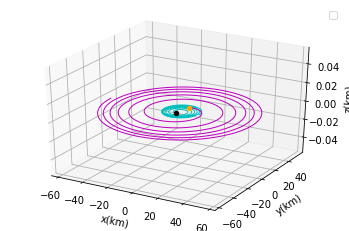

In [64]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(rPNS[0][0], rPNS[0][1], rPNS[0][2], 'c', linewidth=1)# Plot the BH orbit
ax.plot(rPNS[1][0], rPNS[1][1], rPNS[1][2], 'm', linewidth=1)# Plot the star orbit
ax.scatter3D(rPNS[0][0][-1], rPNS[0][1][-1], rPNS[0][2][-1], 'o', c='black') #s=100
ax.scatter3D(rPNS[1][0][-1], rPNS[1][1][-1], rPNS[1][2][-1], 'o', c='orange') #s=10
ax.legend()
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])
#ax.set_xlim3d(-1,1)
#ax.set_ylim3d(-1,1)
#ax.set_xlim3d(min(min(posbh1x), min(posbh2x)), max(max(posbh1x), max(posbh2x)))
#ax.set_ylim3d(min(min(posbh1y), min(posbh2y)), max(max(posbh1y), max(posbh2y)))
#ax.set_zlim3d(min(min(posbh1z), min(posbh2z)), max(max(posbh1z), max(posbh2z)))
ax.set_xlabel('x(km)')
ax.set_ylabel('y(km)')
ax.set_zlabel('z(km)')


#plt.savefig('PNorbitaldecay.png', format='png', dpi=200)#, dpi=200
#plt.savefig('PNorbitaldecay.eps', format='eps')#,

plt.show()

In [65]:
rrelPNS = rPNS[0] - rPNS[1]
vrelPNS = vPNS[0] - vPNS[1]
#rfnsbh = rrelnsbh.T[-1]

#Obtain the orbital distance
dPNS = np.zeros(len(rrelPNS.T)) 

for i in range(len(rrelPNS.T)):
    dPNS[i] = np.linalg.norm(rrelPNS.T[i])
    
#Obtain the relative velocity
vnrelPNS = np.zeros(len(vrelPNS.T))

for i in range(len(rrelPNS.T)):
    vnrelPNS[i] = np.linalg.norm(vrelPNS.T[i])
    
vnrelPNSkm = vnrelPNS/kmsec_U*1000/c_SI
timePNSsec = timePNS*time_U

In [66]:
wsPNS = np.zeros([len(dPNS)])

for i in range(len(dPNS)):
    wsPNS[i] = ((bh3.mass+ns.mass)/dPNS[i]**3)**(1./2) 
    
hplusPNS = np.zeros([len(dPNS)]) #Could use Nsteps
#hcrossnsbh = np.zeros([len(dsimnsbh)])
#ro = 1.23*10**(22)#in km. LIGO's first detection, generated by two black holes some 1.3 billion light years away.
ro = 1.23*10**(21)

iangle = np.pi/2# i = pi/2 -> hx vanishes, i = 0 -> h+ and h- have the same amplitude

mu = (bh3.mass*ns.mass)/(bh3.mass+ns.mass)

for i in range(len(dPNS)):
    hplusPNS[i] = (1./ro)*(4*mu*(wsPNS[i]**2)*(dPNS[i]**2)/c_CU**4)*((1+np.cos(iangle)**2)/2)*np.cos(2*wsPNS[i]*timePNS[i])
    #hcross[i] = (1./ro)*(4*mu*(ws[i]**2)*(dsim[i]**2)/c_CU**4)*np.cos(iangle)*np.sin(2*ws[i]*timesimtp[i])
    

# PN + Spin Orbit 

In [67]:
def HermiteUpdatePNSodt(dt, r, v, m, ns, S,I): # m mass of the star
    
    aN = acc(r, m) 
    aS = accspinorb(r,v, m, ns, S,I)
    aPN = accPN(r, v, m)
    a = aN + aS + aPN           # current acceleration
    aNdot = Jerk(r,v,m)
    aPNdot = JerkPN(r, v, a, m)
    aSdot = Jerkspinorb(r, v, m, ns, S)
    adot = aNdot + aSdot + aPNdot # current jerks
    rp = r + dt*v + dt**2/2 * a + dt**3/6* adot   # predict
    vp = v + dt*a + dt**2/2 * adot

    aNp = acc(rp, m)
    aSp = accspinorb(rp, vp, m, ns, S,I)
    aPNp = accPN(rp, vp, m)
    ap = aNp + aSp + aPNp         # predicted acceleration

    aNdotp = Jerk(rp, vp, m)
    aSdotp = Jerkspinorb(rp, vp, m, ns, S)
    aPNdotp = JerkPN(rp, vp, ap, m)
    adotp = aNdotp + aSdotp + aPNdotp  # predicted jerks 
    
    dtp = dt
    
    vc = v + dt/2*(a+ap) - dt**2/12*(adotp-adot)  # correct
    rc = r + dt/2*(v + vp) - dt**2/12 * (ap-a)
    ac = a + dt/2*(adotp + adot)
    aNc = aN + dt/2*(aNdotp + aNdot)
    
    #Spin
    
    b = bccspinorb(r,v,m,ns,S,I) #r,v,m,S,ns,I
    Sp = S + (dt*b) #+ ()*dt/2

    bp = bccspinorb(rp,vp,m,ns,Sp,I)
    Sc = S + (b + bp)*dt/2
    bc = b #+ ()*dt/2 Higher order terms
       
    
    #Sc = S
 
    return rc,vc,Sc, bc, ac, aNc, dtp


def Hermite4thPNSodt(pri,sec, bina, nsteps,Dt):

    N=2
    m = np.ones(N)#/N #Remove the N if not necessary
    m[0]=pri.mass
    m[1]=sec.mass
    
    r_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    v_res = np.zeros((2,3,nsteps))
    S_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    b_res = np.zeros((2,3,nsteps-1))

    aN_res = np.zeros((2,3,nsteps-1)) # 2 because of two bodies
    #adotN_res = np.zeros((2,3,nsteps))

    a_res = np.zeros((2,3,nsteps-1)) # 2 because of two bodies
    #adot_res = np.zeros((2,3,nsteps))

    
    time = np.zeros(nsteps)
    r_res[:,:,0] = bina.r.copy()
    v_res[:,:,0] = bina.v.copy()
    S_res[:,:,0] = bina.S.copy()
    
    nspinv = np.array([pri.nspin, sec.nspin])
    Iv = np.array([pri.inertiam, sec.inertiam])
    
    dtp = np.zeros(nsteps)
    dtp[0] = Dt
    
    for i in range(1,nsteps):
        (r_res[:,:,i], v_res[:,:,i], S_res[:,:,i], b_res[:,:,i-1] , a_res[:,:,i-1],aN_res[:,:,i-1], dtp[i]) = HermiteUpdatePNSodt(Dt, r_res[:,:,i-1], v_res[:,:,i-1],  m, nspinv, S_res[:,:,i-1], Iv)
        #
        time[i] = time[i-1] + Dt#
        if time[i] >= timelimit:
            break
        elif np.linalg.norm(r_res[0].T[i] - r_res[1].T[i]) < 1.*(bina.tidalrsec):
            break
            
    r_res = r_res[:,:,:i+1]
    v_res = v_res[:,:,:i+1]
    a_res = a_res[:,:,:i]
    aN_res = aN_res[:,:,:i]
    b_res = b_res[:,:,:i]
    S_res = S_res[:,:,:i+1]
    dtp = dtp[:i+1]
    time = time[:i+1]

    return r_res, v_res, S_res, b_res, a_res, aN_res, time

In [108]:
#tl = 8*bh3nsspin.periodct #Time of the simulation in [cpde units]
#timelimit = tl #
#dt = 0.01 # 0.0001 working better 
#Nsteps = int(tl/dt)#Number of ti

rPNSo,vPNSo,S_PNSo,b_PNSo,a_PNSo,aN_PNSo, timePNSo = Hermite4thPNSodt(bh3,nsspin, bh3nsspin, Nsteps, dt)

No handles with labels found to put in legend.


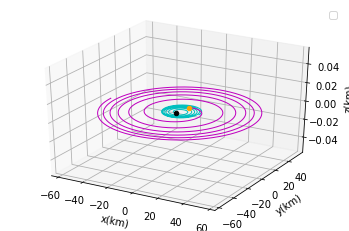

In [109]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(rPNSo[0][0], rPNSo[0][1], rPNSo[0][2], 'c', linewidth=1)# Plot the BH orbit
ax.plot(rPNSo[1][0], rPNSo[1][1], rPNSo[1][2], 'm', linewidth=1)# Plot the star orbit
ax.scatter3D(rPNSo[0][0][-1], rPNSo[0][1][-1], rPNSo[0][2][-1], 'o', c='black') #s=100
ax.scatter3D(rPNSo[1][0][-1], rPNSo[1][1][-1], rPNSo[1][2][-1], 'o', c='orange') #s=10
ax.legend()
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])
#ax.set_xlim3d(-1,1)
#ax.set_ylim3d(-1,1)
#ax.set_xlim3d(min(min(posbh1x), min(posbh2x)), max(max(posbh1x), max(posbh2x)))
#ax.set_ylim3d(min(min(posbh1y), min(posbh2y)), max(max(posbh1y), max(posbh2y)))
#ax.set_zlim3d(min(min(posbh1z), min(posbh2z)), max(max(posbh1z), max(posbh2z)))
ax.set_xlabel('x(km)')
ax.set_ylabel('y(km)')
ax.set_zlabel('z(km)')


#plt.savefig('PNorbitaldecay.png', format='png', dpi=200)#, dpi=200
#plt.savefig('PNorbitaldecay.eps', format='eps')#,

plt.show()

In [110]:
rrelPNSo = rPNSo[0] - rPNSo[1]
vrelPNSo = vPNSo[0] - vPNSo[1]
#rfnsbh = rrelnsbh.T[-1]

#Obtain the orbital distance
dPNSo = np.zeros(len(rrelPNSo.T)) 

for i in range(len(rrelPNSo.T)):
    dPNSo[i] = np.linalg.norm(rrelPNSo.T[i])
    
#Obtain the relative velocity
vnrelPNSo = np.zeros(len(vrelPNSo.T))

for i in range(len(rrelPNSo.T)):
    vnrelPNSo[i] = np.linalg.norm(vrelPNSo.T[i])
    
vnrelPNSokm = vnrelPNSo/kmsec_U*1000/c_SI
timePNSosec = timePNSo*time_U

In [111]:
wsPNSo = np.zeros([len(dPNSo)])

for i in range(len(dPNSo)):
    wsPNSo[i] = ((bh3.mass+ns.mass)/dPNSo[i]**3)**(1./2) 
    
hplusPNSo = np.zeros([len(dPNSo)]) #Could use Nsteps
#hcrossnsbh = np.zeros([len(dsimnsbh)])
#ro = 1.23*10**(22)#in km. LIGO's first detection, generated by two black holes some 1.3 billion light years away.
ro = 1.23*10**(21)

iangle = np.pi/2# i = pi/2 -> hx vanishes, i = 0 -> h+ and h- have the same amplitude

mu = (bh3.mass*ns.mass)/(bh3.mass+ns.mass)

for i in range(len(dPNSo)):
    hplusPNSo[i] = (1./ro)*(4*mu*(wsPNSo[i]**2)*(dPNSo[i]**2)/c_CU**4)*((1+np.cos(iangle)**2)/2)*np.cos(2*wsPNSo[i]*timePNSo[i])
    #hcross[i] = (1./ro)*(4*mu*(ws[i]**2)*(dsim[i]**2)/c_CU**4)*np.cos(iangle)*np.sin(2*ws[i]*timesimtp[i])
    

# PN + Tidal Spin  

In [72]:
def HermiteUpdatespinbdt(dt, r, v, m, ns, S,I): # m mass of the star
    
    aN = acc(r, m) 
    aS = accspin(r, m, ns, S)
    aPN = accPN(r, v, m)
    a = aN + aS + aPN          # current acceleration
    aNdot = Jerk(r,v,m)
    aSdot = Jerkspin(r, v, m, ns, S)
    aPNdot = JerkPN(r, v, a, m)
    adot = aNdot + aSdot + aPNdot # current jerks
    rp = r + dt*v + dt**2/2 * a + dt**3/6* adot   # predict
    vp = v + dt*a + dt**2/2 * adot

    aNp = acc(rp, m)
    aSp = accspin(rp, m, ns, S)
    aPNp = accPN(rp, vp, m)
    ap = aNp + aSp + aPNp         # predicted acceleration

    aNdotp = Jerk(rp, vp, m)
    aSdotp = Jerkspin(rp, vp, m, ns, S)
    aPNdotp = JerkPN(rp, vp, ap, m)
    adotp = aNdotp + aSdotp + aPNdotp # predicted jerks 
    
    dtp = dt
    
    vc = v + dt/2*(a+ap) - dt**2/12*(adotp-adot)  # correct
    rc = r + dt/2*(v + vp) - dt**2/12 * (ap-a)
    ac = a + dt/2*(adotp + adot)
    aNc = aN + dt/2*(aNdotp + aNdot)
    aPNc = aPN + dt/2*(aPNdotp + aPNdot)
    
    #Spin
    
    b = bccspin(r,v,m,ns,S,I) #r,v,m,S,ns,I
    Sp = S + (dt*b) #+ ()*dt/2

    bp = bccspin(rp,vp,m,ns,Sp,I)
    Sc = S + (b + bp)*dt/2
    bc = b #+ ()*dt/2 Higher order terms
       
    #Sc = S
 
    return rc,vc,Sc, bc, ac, aNc,aPNc, dtp

def Hermite4thspinbdt(pri,sec, bina, nsteps,Dt):

    N=2
    m = np.ones(N)#/N #Remove the N if not necessary
    m[0]=pri.mass
    m[1]=sec.mass
    
    r_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    v_res = np.zeros((2,3,nsteps))
    S_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    b_res = np.zeros((2,3,nsteps-1))

    aN_res = np.zeros((2,3,nsteps-1)) # 2 because of two bodies
    #adotN_res = np.zeros((2,3,nsteps))
    aPN_res = np.zeros((2,3,nsteps-1)) # 2 because of two bodies

    a_res = np.zeros((2,3,nsteps-1)) # 2 because of two bodies
    #adot_res = np.zeros((2,3,nsteps))

    
    time = np.zeros(nsteps)
    r_res[:,:,0] = bina.r.copy()
    v_res[:,:,0] = bina.v.copy()
    S_res[:,:,0] = bina.S.copy()
    
    nspinv = np.array([pri.nspin, sec.nspin])
    Iv = np.array([pri.inertiam, sec.inertiam])
    
    dtp = np.zeros(nsteps)
    dtp[0] = Dt
    
    for i in range(1,nsteps):
        (r_res[:,:,i], v_res[:,:,i], S_res[:,:,i], b_res[:,:,i-1] , a_res[:,:,i-1],aN_res[:,:,i-1],aPN_res[:,:,i-1], dtp[i]) = HermiteUpdatespinbdt(Dt, r_res[:,:,i-1], v_res[:,:,i-1],  m, nspinv, S_res[:,:,i-1], Iv)
        #
        time[i] = time[i-1] + Dt#
        if time[i] >= timelimit:
            break
        #elif np.linalg.norm(r_res[0].T[i] - r_res[1].T[i]) < 1.*(pri.radisch+sec.radisch): #This is when running an equal mass bbh
        elif np.linalg.norm(r_res[0].T[i] - r_res[1].T[i]) < 1.*(bina.tidalrsec):
            break
            
    r_res = r_res[:,:,:i+1]
    v_res = v_res[:,:,:i+1]
    a_res = a_res[:,:,:i]
    aN_res = aN_res[:,:,:i]
    aPN_res = aPN_res[:,:,:i]
    b_res = b_res[:,:,:i]
    S_res = S_res[:,:,:i+1]
    dtp = dtp[:i+1]
    time = time[:i+1]

    return r_res, v_res, S_res, b_res, a_res, aN_res, aPN_res, time

In [73]:
rPNSt,vPNSt,S_PNSt,b_PNSt,a_PNSt,aN_PNSt,aPN_PNSt, timePNSt = Hermite4thspinbdt(bh3,nsspin, bh3nsspin, Nsteps, dt)


In [74]:
print(timePNSt[-1])
print(timePNSo[-1])
print(timePNS[-1])

5150.600000001206
5503.3000000024895
5500.000000073632


No handles with labels found to put in legend.


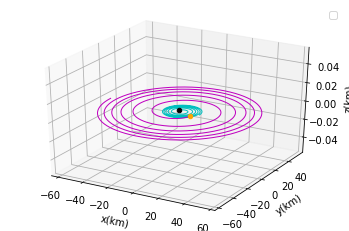

In [75]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(rPNSt[0][0], rPNSt[0][1], rPNSt[0][2], 'c', linewidth=1)# Plot the BH orbit
ax.plot(rPNSt[1][0], rPNSt[1][1], rPNSt[1][2], 'm', linewidth=1)# Plot the star orbit
ax.scatter3D(rPNSt[0][0][-1], rPNSt[0][1][-1], rPNSt[0][2][-1], 'o', c='black') #s=100
ax.scatter3D(rPNSt[1][0][-1], rPNSt[1][1][-1], rPNSt[1][2][-1], 'o', c='orange') #s=10
ax.legend()
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])
#ax.set_xlim3d(-1,1)
#ax.set_ylim3d(-1,1)
#ax.set_xlim3d(min(min(posbh1x), min(posbh2x)), max(max(posbh1x), max(posbh2x)))
#ax.set_ylim3d(min(min(posbh1y), min(posbh2y)), max(max(posbh1y), max(posbh2y)))
#ax.set_zlim3d(min(min(posbh1z), min(posbh2z)), max(max(posbh1z), max(posbh2z)))
ax.set_xlabel('x(km)')
ax.set_ylabel('y(km)')
ax.set_zlabel('z(km)')


#plt.savefig('PNorbitaldecay.png', format='png', dpi=200)#, dpi=200
#plt.savefig('PNorbitaldecay.eps', format='eps')#,

plt.show()

In [76]:
rrelPNSt = rPNSt[0] - rPNSt[1]
vrelPNSt = vPNSt[0] - vPNSt[1]
#rfnsbh = rrelnsbh.T[-1]

#Obtain the orbital distance
dPNSt = np.zeros(len(rrelPNSt.T)) 

for i in range(len(rrelPNSt.T)):
    dPNSt[i] = np.linalg.norm(rrelPNSt.T[i])
    
#Obtain the relative velocity
vnrelPNSt = np.zeros(len(vrelPNSt.T))

for i in range(len(rrelPNSt.T)):
    vnrelPNSt[i] = np.linalg.norm(vrelPNSt.T[i])
    
vnrelPNStkm = vnrelPNSt/kmsec_U*1000/c_SI
timePNStsec = timePNSt*time_U

In [77]:
wsPNSt = np.zeros([len(dPNSt)])

for i in range(len(dPNSt)):
    wsPNSt[i] = ((bh3.mass+ns.mass)/dPNSt[i]**3)**(1./2) 
    
hplusPNSt = np.zeros([len(dPNSt)]) #Could use Nsteps
#hcrossnsbh = np.zeros([len(dsimnsbh)])
#ro = 1.23*10**(22)#in km. LIGO's first detection, generated by two black holes some 1.3 billion light years away.
ro = 1.23*10**(21)

iangle = np.pi/2# i = pi/2 -> hx vanishes, i = 0 -> h+ and h- have the same amplitude

mu = (bh3.mass*ns.mass)/(bh3.mass+ns.mass)

for i in range(len(dPNSt)):
    hplusPNSt[i] = (1./ro)*(4*mu*(wsPNSt[i]**2)*(dPNSt[i]**2)/c_CU**4)*((1+np.cos(iangle)**2)/2)*np.cos(2*wsPNSt[i]*timePNSt[i])
    #hcross[i] = (1./ro)*(4*mu*(ws[i]**2)*(dsim[i]**2)/c_CU**4)*np.cos(iangle)*np.sin(2*ws[i]*timesimtp[i])
    

# PN 

In [78]:
def HermiteUpdatePNtdt(dt, r, v, m, ns): # m mass of the star
    
    aN = acc(r, m) 
    #aD = accdiss(r, m, ns)
    aPN = accPN(r, v, m)
    a = aN + aPN #+ aT # current acceleration
    
    aNdot = Jerk(r,v,m)
    #aDdot = Jerkdiss(r, v, m, ns)
    aPNdot = JerkPN(r, v, a, m)
    adot = aNdot + aPNdot #+ aDdot # current jerks
    
    rp = r + dt*v + dt**2/2 * a + dt**3/6* adot   # predict
    vp = v + dt*a + dt**2/2 * adot

    aNp = acc(rp, m)
    aPNp = accPN(rp, vp, m)
    #aDp = accdiss(rp, m, ns)
    ap = aNp + aPNp #+ aDp        # predicted acceleration

    aNdotp = Jerk(rp, vp, m)
    aPNdotp = JerkPN(rp, vp, ap, m)
    #aDdotp = Jerkdiss(rp, vp, m, ns)
    adotp = aNdotp + aPNdotp #+  aDdotp  # predicted jerks 
    
    #compute some other things to find the best value for the timestep
    #Newtonian
    #a2 = (1./dt**2)*(-6*(a-ap)-dt*(4*adot + 2*adotp))
    #a3 = (1./dt**3)*(-12*(a-ap)-6*dt*(adot + adotp))
    #ac = a + adot*dt + (1./2)*(dt**2)*a2 + (1./6)*(dt**2)*a3 
    
    #Tides
    #a2 = (1./dt**2)*(-6*(aT-aTp)-dt*(4*aTdot + 2*aTdotp))
    #a3 = (1./dt**3)*(-12*(aT-aTp)-6*dt*(aTdot + aTdotp))
    #ac = aT + aTdot*dt + (1./2)*(dt**2)*a2 + (1./6)*(dt**2)*a3    
    
    #a2c = a2 + dt*a3    
    #acn = ((ac**2).sum())**(1./2) #dot product
    #a2cn = ((a2c**2).sum())**(1./2)
    #adotpn = ((aTdotp**2).sum())**(1./2)
    #a3n = ((a3**2).sum())**(1./2)
    #dtp = (accu*(acn*a2cn + adotpn**2)/(adotpn*a3n + a2cn**2))**(1./2)

    dtp = dt
    
    vp = v + dt/2*(a+ap) - dt**2/12*(adotp-adot)  # correct
    rp = r + dt/2*(v + vp) - dt**2/12 * (ap-a)
 
    return rp,vp,dtp #ap,adotp,aNp,aNdotp,

def Hermite4thPNtdt(pri,sec, bina, nsteps, Dt):
    
    N=2
    m = np.ones(N)#/N #Remove the N if not necessary
    m[0]=pri.mass
    m[1]=sec.mass
    
    r_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    v_res = np.zeros((2,3,nsteps))

    aN_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    adotN_res = np.zeros((2,3,nsteps))

    a_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    adot_res = np.zeros((2,3,nsteps))

    
    time = np.zeros(nsteps)
    r_res[:,:,0] = bina.r.copy()
    v_res[:,:,0] = bina.v.copy()
    ntidev = np.array([pri.eta, sec.eta])
    
    dtp = np.zeros(nsteps)
    dtp[0] = Dt
    
    for i in range(1,nsteps):
        (r_res[:,:,i],v_res[:,:,i], dtp[i]) = HermiteUpdatePNtdt(Dt, r_res[:,:,i-1], v_res[:,:,i-1], m, ntidev)
        time[i] = time[i-1] + dtp[i-1] #+ Dt #
        if time[i] >= timelimit:
            break
        elif np.linalg.norm(r_res[0].T[i] - r_res[1].T[i]) < 1.*(bina.tidalrsec): #This is when running an equal mass bbh
        #elif np.linalg.norm(r_res[0].T[i] - r_res[1].T[i]) < 1.*(bina.tidalrsec):
            break
    
    
    #for i in range(1,nsteps):
    #    (r_res[:,:,i],v_res[:,:,i],a_res[:,:,i],adot_res[:,:,i],aN_res[:,:,i],adotN_res[:,:,i], dtp[i]) = HermiteUpdatetidedt(Dt, r_res[:,:,i-1], v_res[:,:,i-1], m, ntidev)
    #    time[i] = time[i-1] + dtp[i-1] #+ Dt #
    #    if time[i] >= timelimit:
    #        break
            
    r_res = r_res[:,:,:i]
    v_res = v_res[:,:,:i]
    a_res = a_res[:,:,:i]
    adot_res = adot_res[:,:,:i]
    aN_res = aN_res[:,:,:i]
    adotN_res = adotN_res[:,:,:i]
    dtp = dtp[:i]
    time = time[:i]
        
    return r_res, v_res, time #, aN_res, adotN_res, a_res, adot_res, 


In [79]:
rPN,vPN,timePN = Hermite4thPNtdt(bh3,nsspin, bh3nsspin, Nsteps, dt)

In [80]:
rrelPN = rPN[0] - rPN[1]
vrelPN = vPN[0] - vPN[1]
#rfnsbh = rrelnsbh.T[-1]

#Obtain the orbital distance
dPN = np.zeros(len(rrelPN .T)) 

for i in range(len(rrelPN.T)):
    dPN[i] = np.linalg.norm(rrelPN.T[i])
    
#Obtain the relative velocity
vnrelPN = np.zeros(len(vrelPN.T))

for i in range(len(rrelPN.T)):
    vnrelPN[i] = np.linalg.norm(vrelPN.T[i])
    
vnrelPNkm = vnrelPN/kmsec_U*1000/c_SI
timePNsec = timePN*time_U

In [81]:
wsPN = np.zeros([len(dPN)])

for i in range(len(dPN)):
    wsPN[i] = ((bh3.mass+nsspin.mass)/dPN[i]**3)**(1./2) 
    
hplusPN = np.zeros([len(dPN)]) #Could use Nsteps
#hcrossnsbh = np.zeros([len(dsimnsbh)])
#ro = 1.23*10**(22)#in km. LIGO's first detection, generated by two black holes some 1.3 billion light years away.
ro = 1.23*10**(21)

iangle = np.pi/2# i = pi/2 -> hx vanishes, i = 0 -> h+ and h- have the same amplitude

mu = (bh3.mass*nsspin.mass)/(bh3.mass+nsspin.mass)

for i in range(len(dPN)):
    hplusPN[i] = (1./ro)*(4*mu*(wsPN[i]**2)*(dPN[i]**2)/c_CU**4)*((1+np.cos(iangle)**2)/2)*np.cos(2*wsPN[i]*timePN[i])
    #hcross[i] = (1./ro)*(4*mu*(ws[i]**2)*(dsim[i]**2)/c_CU**4)*np.cos(iangle)*np.sin(2*ws[i]*timesimtp[i])
    

# Comparison of Waveforms 

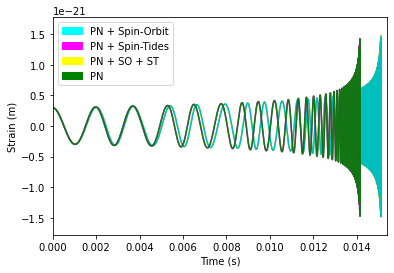

In [89]:
cyan_patch = mpatches.Patch(color='cyan', label=r'PN + Spin-Orbit')
magenta_patch = mpatches.Patch(color='magenta', label=r'PN + Spin-Tides')
yellow_patch = mpatches.Patch(color='yellow', label=r'PN + SO + ST')
green_patch = mpatches.Patch(color='green', label=r'PN')
plt.legend(handles=[cyan_patch, magenta_patch, yellow_patch, green_patch])
plt.plot(timePNSsec, hplusPNS, 'y-', alpha = 0.9)
plt.plot(timePNSosec, hplusPNSo, 'c-')
plt.plot(timePNStsec, hplusPNSt, 'm-', alpha = 0.9)
plt.plot(timePNsec, hplusPN, 'g-', alpha = 0.9)

plt.axis([0.0, 1.02*max(timePNSsec), 1.2*min(hplusPNS), 1.2*max(hplusPNS)])
plt.xlabel('Time (s)')
plt.ylabel('Strain (m)')
#plt.savefig('gw-PNTO1-10nsradi.eps', bbox_inches='tight') #, dpi=300
#plt.savefig('gw-PNTO.png', bbox_inches='tight', dpi=200) #, dpi=300
plt.show()

Text(0, 0.5, 'Strain (m)')

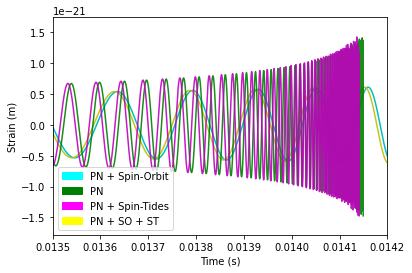

In [94]:
cyan_patch = mpatches.Patch(color='cyan', label=r'PN + Spin-Orbit')
magenta_patch = mpatches.Patch(color='magenta', label=r'PN + Spin-Tides')
yellow_patch = mpatches.Patch(color='yellow', label=r'PN + SO + ST')
plt.legend(handles=[cyan_patch, green_patch, magenta_patch, yellow_patch])
plt.plot(timePNSosec, hplusPNSo, 'c-')
plt.plot(timePNSsec, hplusPNS, 'y-', alpha = 0.9)
plt.plot(timePNsec, hplusPN, 'g-', alpha = 0.9)
plt.plot(timePNStsec, hplusPNSt, 'm-', alpha = 0.9)
plt.axis([0.0135, 0.0142, 1.2*min(hplusPNSo), 1.2*max(hplusPNSo)])
plt.xlabel('Time (s)')
plt.ylabel('Strain (m)')
#plt.savefig('gw-PNTO1-10nsradi.eps', bbox_inches='tight') #, dpi=300
#plt.savefig('gw-PNTO

Text(0, 0.5, 'Strain (m)')

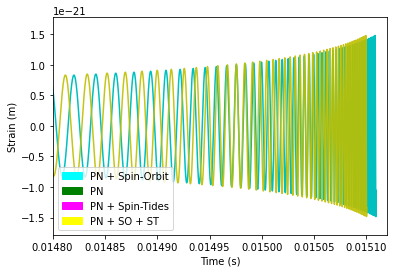

In [112]:
cyan_patch = mpatches.Patch(color='cyan', label=r'PN + Spin-Orbit')
magenta_patch = mpatches.Patch(color='magenta', label=r'PN + Spin-Tides')
yellow_patch = mpatches.Patch(color='yellow', label=r'PN + SO + ST')
plt.legend(handles=[cyan_patch, green_patch, magenta_patch, yellow_patch])
plt.plot(timePNSosec, hplusPNSo, 'c-')
plt.plot(timePNSsec, hplusPNS, 'y-', alpha = 0.9)
plt.plot(timePNsec, hplusPN, 'g-', alpha = 0.9)
plt.plot(timePNStsec, hplusPNSt, 'm-', alpha = 0.9)
plt.axis([0.0148, 0.01512, 1.2*min(hplusPNSo), 1.2*max(hplusPNSo)])
plt.xlabel('Time (s)')
plt.ylabel('Strain (m)')
#plt.savefig('gw-PNTO1-10nsradi.eps', bbox_inches='tight') #, dpi=300
#plt.savefig('gw-PNTO

In [104]:
print(S[1].T[0])
print(S[1].T[-1])
print(S[1].T[-1][2]/S[1].T[0][2])

[0.         0.         0.00528389]
[0.         0.         0.00528381]
0.9999855615106075
